# Shoe Brand Classification | Multiclass Classification using Transfer Learning

## Project steps:
1. Primary goal of the project
2. Data overview
3. Data preprocessing and EDA
4. Model building
5. Model training
6. Model evaluation and tuning
7. Model testing 
8. Conclusion
9. References

## 1. Primary goal of the project

The primary goal of this project is to employ transfer learning with the InceptionV3 model, a deep convolutional neural network (CNN) architecture developed by Google's research team, which is primarily designed for image classification and object recognition tasks. Our objective is to use this powerful architecture to categorize images of shoes into three distinct brands: Nike, Adidas, and Converse.

## 2. Data overview

The dataset is structured into two folders, one for test data and the other for training data, with a test-train-split ratio of 0.14. The test dataset comprises 114 images, while the training dataset consists of 711 images. All images are in RGB color format and have a resolution of 240x240 pixels. Within both folders, there are three distinct classes: Adidas, Converse, and Nike.

This dataset was acquired by downloading images from Google Images. Images in .webp format were converted to .jpg format. Subsequently, the images were randomly shuffled and resized to ensure a consistent resolution of 240x240 pixels for all samples.

## 3. Data preprocessing and EDA

### Importing Libraries:

In [33]:
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
base_dir = '../input/nike-adidas-and-converse-imaged/train'

### Let's confirm that our data is balanced accross all three classes:

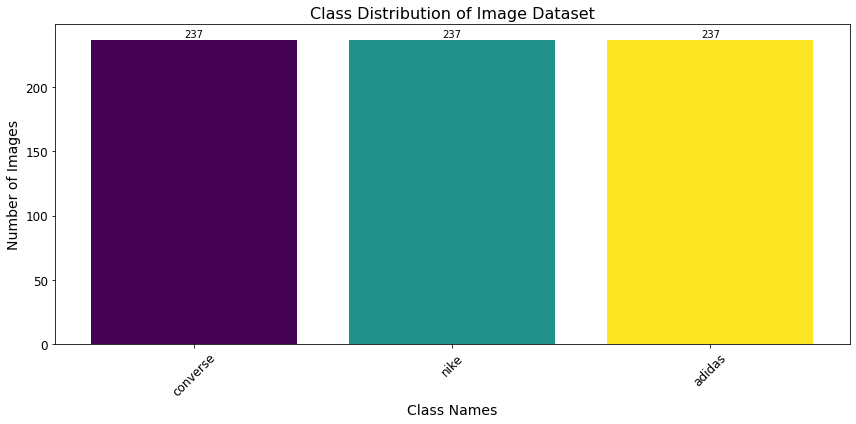

In [3]:
# Initialize an empty dictionary to store class counts
class_counts = {}

# Loop through the subdirectories (classes) in your dataset directory
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of images in each class
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images

# Extract class names and counts
class_names = list(class_counts.keys())
class_counts = list(class_counts.values())

# Create a color map for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))

# Create a bar plot to visualize class distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_counts, color=colors)
plt.xlabel('Class Names', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution of Image Dataset', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add text labels with the exact counts above each bar
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Let's visualize a random sample of images from our dataset, which can help us assess the quality of the data, check for any potential issues, and get a sense of the visual characteristics of our dataset:

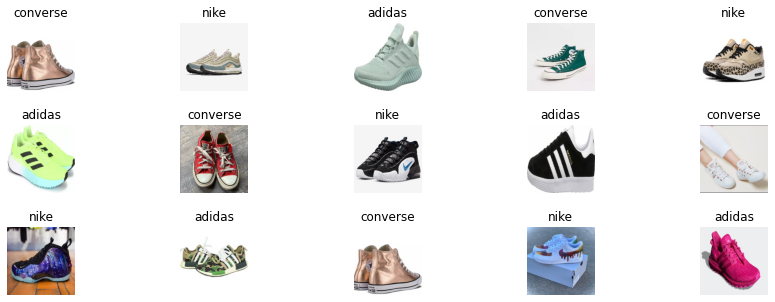

In [4]:
num_samples = 5 

# Create a list of class names (subdirectories)
class_names = os.listdir(base_dir)

# Initialize a Matplotlib figure for displaying the sample images
plt.figure(figsize=(15, 5))

# Loop through the class names to display random samples
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        # List all image files in the class directory
        image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

        # Randomly select and display a sample of images
        for i in range(num_samples):
            # Randomly select an image file
            random_image_file = random.choice(image_files)

            # Load and display the image using OpenCV
            image_path = os.path.join(class_dir, random_image_file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            plt.subplot(len(class_names), num_samples, len(class_names) * i + class_names.index(class_name) + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

# Adjust spacing between subplots and display the figure
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Load Images For Training & Testing:


Using `ImageDataGenerator` to load the Images for training and validating the CNN model.

In [5]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=base_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1. / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=base_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 642 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


In summary, this code sets up data generators for training and validation data for a deep learning model. The generators will provide augmented and preprocessed batches of images from the specified directory during training and validation. The data augmentation techniques applied here help improve the model's ability to generalize to new data by introducing variations in the training images.

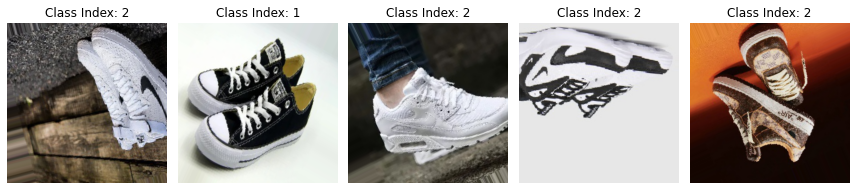

In [6]:
# Create a generator for images in the specified subset
image_generator = datagenerator["train"]

# Generate and visualize augmented images
num_samples = 5  # Adjust the number of augmented images to display
plt.figure(figsize=(12, 6))

for i in range(num_samples):
    augmented_image, class_label = next(image_generator)  # Generate the next augmented image
    image = augmented_image[0]  # Extract the image data from the generator output
    class_index = np.argmax(class_label[0])  # Convert one-hot encoded label to index

    # Display the augmented image
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.title(f'Class Index: {class_index}')
    plt.axis('off')

plt.tight_layout()
plt.show()

It's evident that our `datagenerator` is functioning as expected.

### Initialize InceptionV3 pretrained model:


In [7]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

The provided code initializes and configures the InceptionV3 model for image-related deep learning tasks. It sets up the model with random weights, excluding its top layers, and specifies an input image shape of 300x300 pixels with 3 color channels (RGB). Pre-trained weights, loaded from a file, are used to initialize the model, leveraging valuable features learned from a large dataset. Furthermore, all layers of the InceptionV3 model are frozen, preventing their weights from being updated during training. This freezing is particularly useful for utilizing pre-trained knowledge without modification, which can be advantageous when dealing with limited data or aiming to prevent overfitting. 

### Adding a custom layer


In [23]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax') 
])

Overall, this code extends the InceptionV3 model with additional layers to create a sequential neural network. The added layers perform global average pooling, introduce dropout for regularization, and incorporate fully connected layers for feature extraction and classification. The final output layer provides class probabilities for the three classes in our classification task. 

In [24]:
# Using the Adam Optimizer to set the learning rate of our final model
o = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer= o, metrics=['accuracy'])

With these settings, our model is now configured to use the Adam optimizer with a specific learning rate of 0.0001 for training. It will minimize the categorical cross-entropy loss and track the accuracy metric during the training process. 

### View model summary & plot


In [25]:
# Viewing the summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 3075      
Total params: 23,904,035
Trainable params: 2,101,251
Non-trainable params: 21,802,784
_________________________________________________________________


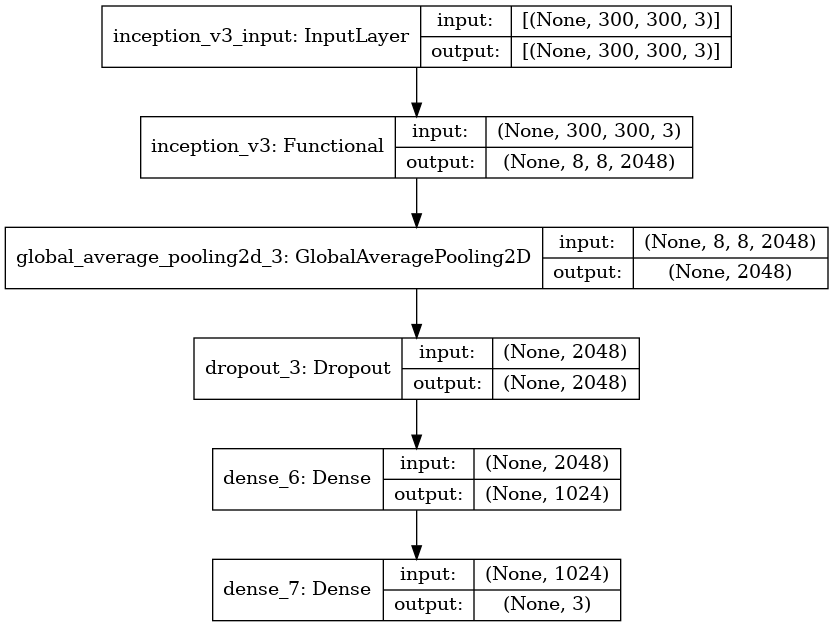

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

This graphical representation provides a clear and concise overview of the model's structure, making it easier to understand its configuration and flow of data, which is particularly helpful for communication, model inspection, and debugging in deep learning projects.

# 4. Model Building


In [27]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [28]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 20
validation_steps : 2


In this step, we established final amount of `batch_size` and `epochs`, also by creating `steps_per_epoch` and `validation_steps` we will gain insight into how many iterations (or batches) are processed during each training epoch and each validation epoch. These values are crucial for setting up the training loop, ensuring that the model processes the entire dataset in a structured manner while training and validating its performance.

# 5. Model Training


During training, the model will run for the specified number of epochs, and the ModelCheckpoint callback will save the best models based on validation accuracy into files named according to the specified file path format. This allows us to keep track of the model's progress and have access to the best-performing model for later use or evaluation.

In [29]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
20/20 [==============================] - 20s 807ms/step - loss: 1.0910 - accuracy: 0.4148 - val_loss: 0.9387 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to ./model_01-0.62.h5
Epoch 2/10
20/20 [==============================] - 15s 723ms/step - loss: 0.9208 - accuracy: 0.5562 - val_loss: 0.8876 - val_accuracy: 0.6406

Epoch 00002: val_accuracy improved from 0.62500 to 0.64062, saving model to ./model_02-0.64.h5
Epoch 3/10
20/20 [==============================] - 15s 727ms/step - loss: 0.8121 - accuracy: 0.6393 - val_loss: 0.8065 - val_accuracy: 0.7031

Epoch 00003: val_accuracy improved from 0.64062 to 0.70312, saving model to ./model_03-0.70.h5
Epoch 4/10
20/20 [==============================] - 14s 735ms/step - loss: 0.7840 - accuracy: 0.6623 - val_loss: 0.7511 - val_accuracy: 0.7344

Epoch 00004: val_accuracy improved from 0.70312 to 0.73438, saving model to ./model_04-0.73.h5
Epoch 5/10
20/20 [=============================

During the training of a machine learning model over 10 epochs, several key statistics and events are displayed. Each epoch represents one complete pass through the training dataset. In Epoch 9, there is a notable improvement in validation accuracy, reaching 81.25%. This improvement triggers the saving of the model with the best validation accuracy to a file. 

# 6. Model Evaluation and Tuning


In [9]:
model_tuned = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax') 
])

In [10]:
# Using the Adam Optimizer to set the learning rate of our final model
o_tuned = optimizers.Adam(learning_rate=0.001)

# Compiling and setting the parameters we want our model to use
model_tuned.compile(loss="categorical_crossentropy", optimizer= o_tuned, metrics=['accuracy'])

In [11]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [12]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 20
validation_steps : 2


In [13]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model_tuned.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
20/20 [==============================] - 27s 814ms/step - loss: 1.8572 - accuracy: 0.3689 - val_loss: 1.0953 - val_accuracy: 0.3438

Epoch 00001: val_accuracy improved from -inf to 0.34375, saving model to ./model_01-0.34.h5
Epoch 2/10
20/20 [==============================] - 16s 778ms/step - loss: 0.9157 - accuracy: 0.5410 - val_loss: 0.8699 - val_accuracy: 0.6094

Epoch 00002: val_accuracy improved from 0.34375 to 0.60938, saving model to ./model_02-0.61.h5
Epoch 3/10
20/20 [==============================] - 15s 731ms/step - loss: 0.7837 - accuracy: 0.6590 - val_loss: 0.8087 - val_accuracy: 0.6875

Epoch 00003: val_accuracy improved from 0.60938 to 0.68750, saving model to ./model_03-0.69.h5
Epoch 4/10
20/20 [==============================] - 14s 706ms/step - loss: 0.7299 - accuracy: 0.6852 - val_loss: 0.7634 - val_accuracy: 0.7188

Epoch 00004: val_accuracy improved from 0.68750 to 0.71875, saving model to ./model_04-0.72.h5
Epoch 5/10
20/20 [=============================

We conducted model tuning experiments by adjusting the `learning rate` to `0.001` and increasing the number of training `epochs`. However, it became evident that these modifications resulted in a less effective model compared to the initial configuration. It appears that my initial choices regarding batch size, learning rate, and the number of epochs were the most efficient and productive.

The original model achieved the highest `validation accuracy` of `81.25%` during the ninth epoch, while the tuned model reached its best `validation accuracy` of `73.44%` during the seventh epoch. Based on these results, we have decided to proceed with the original model, as it has demonstrated superior performance in terms of validation accuracy.

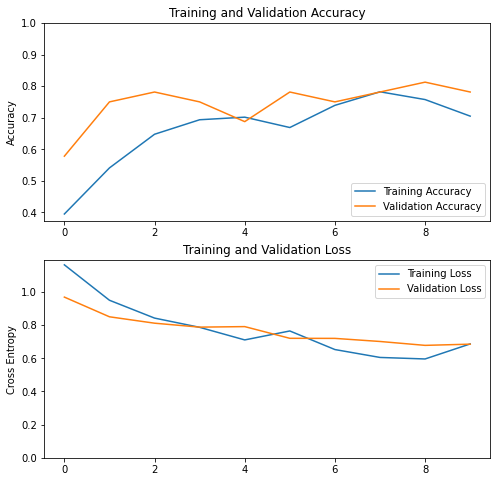

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

3/3 [==============================] - 1s 262ms/step - loss: 0.6689 - accuracy: 0.7826
test accuracy :  0.782608687877655


In [31]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("./model_09-0.81.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'adidas', 1: 'converse', 2: 'nike'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

# 7. Model Testing With Graphs


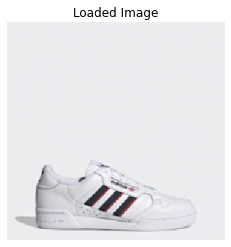



Maximum Probability:  0.7720875
Classified: adidas 



-------------------Individual Probability--------------------------------

ADIDAS : 77.21 %
CONVERSE : 8.98 %
NIKE : 13.81 %


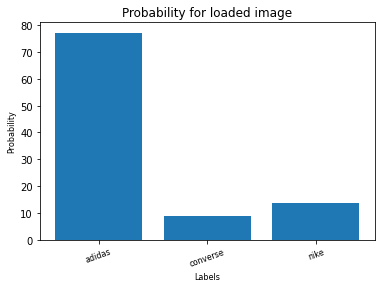

In [36]:
predict("../input/nike-adidas-shoes-for-image-classification-dataset/validation/adidas/adidas_ (149).jpg")

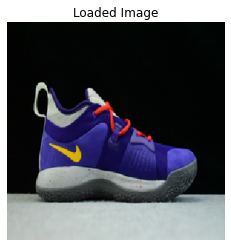



Maximum Probability:  0.62257147
Classified: nike 



-------------------Individual Probability--------------------------------

ADIDAS : 27.15 %
CONVERSE : 10.59 %
NIKE : 62.26 %


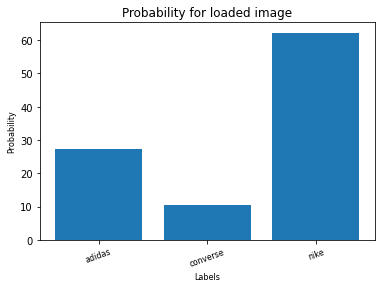

In [46]:
predict("../input/nike-adidas-shoes-for-image-classification-dataset/validation/nike/Image_261.jpg")

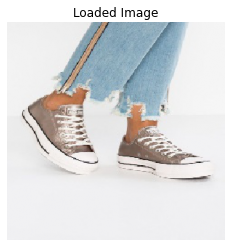



Maximum Probability:  0.8196125
Classified: converse 



-------------------Individual Probability--------------------------------

ADIDAS : 10.08 %
CONVERSE : 81.96 %
NIKE : 7.96 %


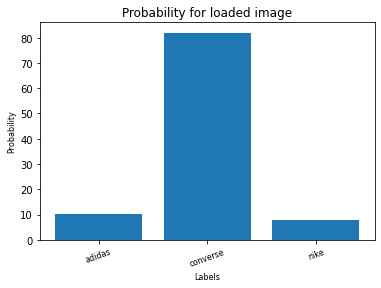

In [40]:
predict("../input/nike-adidas-and-converse-imaged/test/converse/28.jpg")

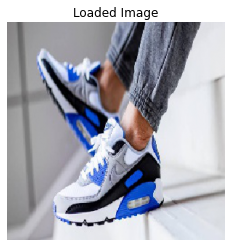



Maximum Probability:  0.6115109
Classified: nike 



-------------------Individual Probability--------------------------------

ADIDAS : 22.0 %
CONVERSE : 16.85 %
NIKE : 61.15 %


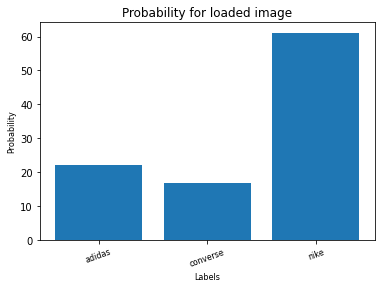

In [38]:
predict("../input/nike-adidas-and-converse-imaged/test/nike/24.jpg")

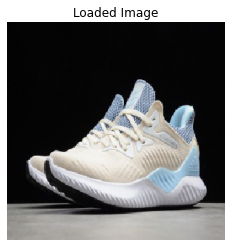



Maximum Probability:  0.55260277
Classified: adidas 



-------------------Individual Probability--------------------------------

ADIDAS : 55.26 %
CONVERSE : 11.19 %
NIKE : 33.55 %


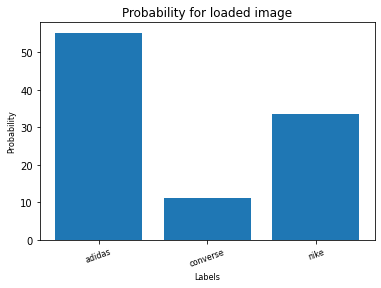

In [48]:
predict("../input/nike-adidas-and-converse-imaged/test/adidas/13.jpg")

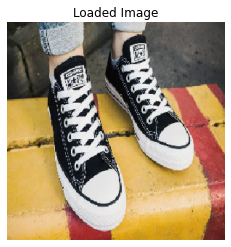



Maximum Probability:  0.555709
Classified: converse 



-------------------Individual Probability--------------------------------

ADIDAS : 7.88 %
CONVERSE : 55.57 %
NIKE : 36.54 %


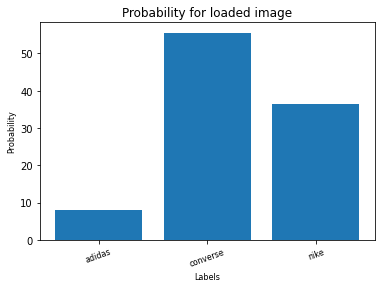

In [53]:
predict("../input/nike-adidas-and-converse-imaged/test/converse/25.jpg")

In the next example we will see one missclasified image. Further tuning will be needed in order to get better performance and accuracy.

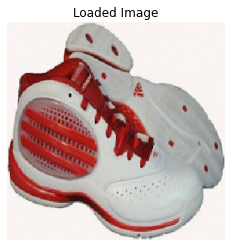



Maximum Probability:  0.54862535
Classified: converse 



-------------------Individual Probability--------------------------------

ADIDAS : 17.27 %
CONVERSE : 54.86 %
NIKE : 27.87 %


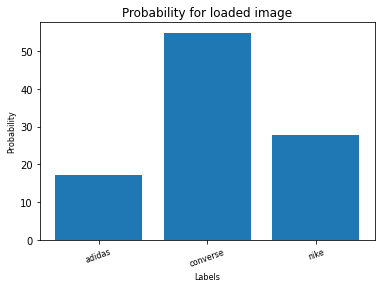

In [46]:
predict("../input/nike-adidas-and-converse-imaged/test/adidas/17.jpg")

The test accuracy of 78% represents a promising result, indicating that the model has learned and generalized well to unseen data. Additionally, during our testing phase, the model exhibited successful brand identification and accurate classification based on input images.

# 8. Conclusion and further exploration



In this project, we embarked on the task of image classification for different shoe brands, namely Adidas, Converse, and Nike. We developed a deep learning model based on the InceptionV3 architecture, which demonstrated promising results. Through training and evaluation, we achieved a respectable test accuracy of 78%, indicating the model's ability to generalize well to unseen data. Moreover, our model successfully classified brand logos based on input images, showcasing its practical applicability.

**Future Improvements:**

While we've made significant progress in this project, there are several avenues for future improvements and enhancements:

- Data Augmentation: Expanding the dataset through data augmentation techniques can further improve model robustness and generalization.

- Fine-Tuning: Experimenting with fine-tuning, transfer learning, and different pre-trained models may lead to even higher accuracy.

- Hyperparameter Tuning: Systematic hyperparameter tuning, including learning rate and batch size, can potentially optimize model convergence.

- Regularization: Implementing advanced regularization techniques, such as dropout and L2 regularization, can help combat overfitting.

- Ensemble Learning: Combining multiple models through ensemble learning methods may enhance classification accuracy.

- Advanced Metrics: Incorporating advanced evaluation metrics like precision, recall, and F1-score can provide a more comprehensive understanding of model performance.

- Interpretability: Incorporating interpretability techniques to explain model predictions can increase trust and identify areas for improvement.

- Continuous Monitoring: Implementing a system for continuous monitoring and retraining of the model to adapt to changing data distributions.

By addressing these areas, we can further refine and optimize our image classification model, making it more accurate and robust in real-world scenarios. Additionally, staying abreast of advancements in deep learning and computer vision will be crucial for maintaining the model's effectiveness over time.

# 9. References

1. Dataset: https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged/data?select=train
2. InceptionV3 : https://www.kaggle.com/code/kmader/transfer-learning-with-inceptionv3
3. Inspiration: https://www.kaggle.com/code/aryashah2k/shoe-brand-classification-nike-adidas-converse 